In [42]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from google.colab import files
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# daba_batch 불러오기
uploaded = files.upload()

Saving data_batch_3 to data_batch_3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
data = unpickle('data_batch_1')

In [6]:
def load_data(data, labels):
    # 데이터셋의 이미지 개수
    num_images = data.shape[0]

     # (10000, 3072) 형태인 데이터를 (10000, 3, 32, 32) 형태로 변경
    images = np.reshape(data, (num_images, 32, 32, 3), order='F')

    # (10000, 3, 32, 32) 형태의 이미지 데이터를 (10000, 32, 32, 3)로 변경
    images = np.swapaxes(images, 1, 2)
    
    # 레이블과 함께 튜플로 반환
    return images, labels
  

In [7]:
images, lbls = load_data(data[b'data'], data[b'labels'])

# 이미지 데이터 정규화
images = images.astype('float32') / 255.

# 데이터를 학습 및 테스트 세트로 분할 (예: 80%는 학습, 20%는 테스트용)
x_train, x_test, y_train, y_test = train_test_split(images, lbls, test_size=0.2)

# 레이블 범주화
# y_train = to_categorical(y_train, 10)
# y_test = to_categorical(y_test, 10)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
def create_cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    # model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

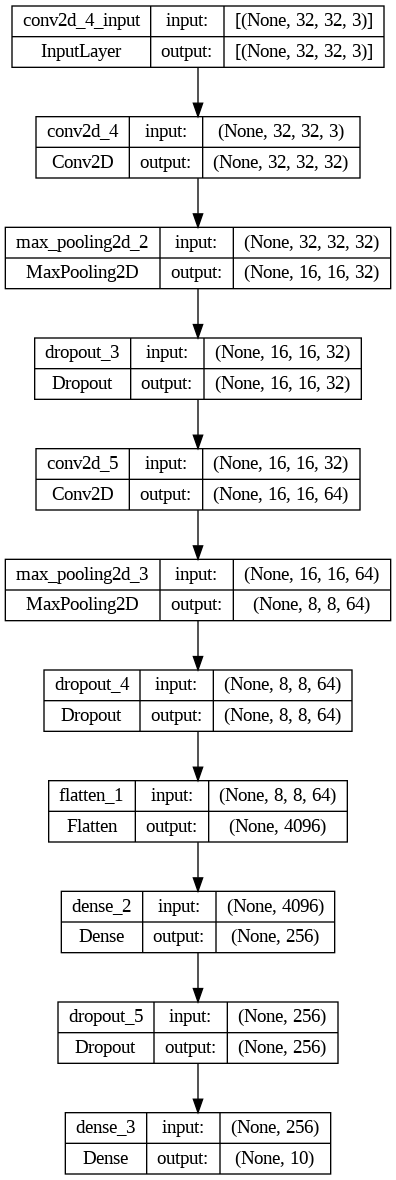

In [12]:
# 모델 생성, 컴파일
model = create_cnn_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)

# 3번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

batch_size = 64
epochs = 100
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# 모델 학습
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping])
# verbose=1 (progress bar): 각 시대에 대한 진행률 표시줄(progress bar)과 함께 손실 및 정확도와 같은 주요 메트릭을 출력

Epoch 1/100
125/125 [==============================] - 20s 152ms/step - loss: 2.2815 - accuracy: 0.1421 - val_loss: 2.2128 - val_accuracy: 0.1725
Epoch 2/100
125/125 [==============================] - 20s 157ms/step - loss: 2.0944 - accuracy: 0.2259 - val_loss: 1.9610 - val_accuracy: 0.3580
Epoch 3/100
125/125 [==============================] - 18s 144ms/step - loss: 1.9241 - accuracy: 0.3046 - val_loss: 1.8508 - val_accuracy: 0.3840
Epoch 4/100
125/125 [==============================] - 19s 156ms/step - loss: 1.8306 - accuracy: 0.3314 - val_loss: 1.7743 - val_accuracy: 0.3955
Epoch 5/100
125/125 [==============================] - 23s 183ms/step - loss: 1.7689 - accuracy: 0.3694 - val_loss: 1.7098 - val_accuracy: 0.4205
Epoch 6/100
125/125 [==============================] - 19s 155ms/step - loss: 1.7230 - accuracy: 0.3781 - val_loss: 1.6792 - val_accuracy: 0.4315
Epoch 7/100
125/125 [==============================] - 18s 145ms/step - loss: 1.6903 - accuracy: 0.3954 - val_loss: 1.6380 -

In [14]:
# 모델 평가
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

63/63 [==============================] - 2s 28ms/step - loss: 1.0719 - accuracy: 0.6205
Test loss: 1.0719484090805054
Test accuracy: 0.6205000281333923


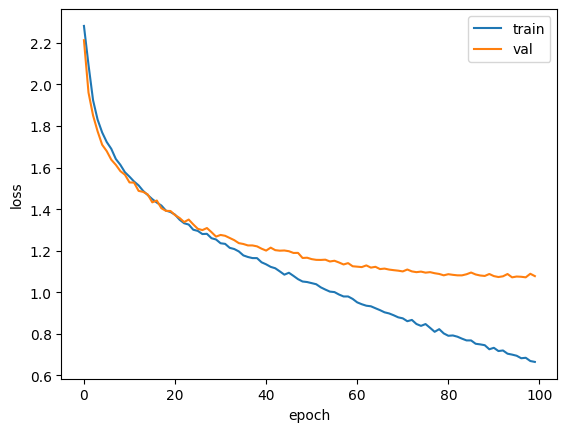

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [37]:
def train_additional_batches(model, filepaths, epochs=20, batch_size=64):

    checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)

    # 3번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
    early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for filepath in filepaths:
        # 데이터 로드 및 전처리
        with open(filepath, 'rb') as f:
            data = pickle.load(f, encoding='bytes')
        images, lbls = load_data(data[b'data'], data[b'labels'])
        images = images.astype('float32') / 255.
        lbls = np.array(lbls)

        x_train, x_test, y_train, y_test = train_test_split(images, lbls, test_size=0.2)

        # 모델 학습
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping])
    return model

In [ ]:
 file_name = ['/content/drive/MyDrive/Colab Notebooks/data/data_batch_2',
  '/content/drive/MyDrive/Colab Notebooks/data/data_batch_3',
  '/content/drive/MyDrive/Colab Notebooks/data/data_batch_4',
  '/content/drive/MyDrive/Colab Notebooks/data/data_batch_5']
 
 # 위의 files.upload()로 다른 data_batch도 불러와야함
 model = train_additional_batches(model, file_name)

In [43]:
model = load_model('best_cnn_model.h5')
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

63/63 [==============================] - 1s 18ms/step - loss: 0.8750 - accuracy: 0.6905
Test loss: 0.8750486373901367
Test accuracy: 0.690500020980835


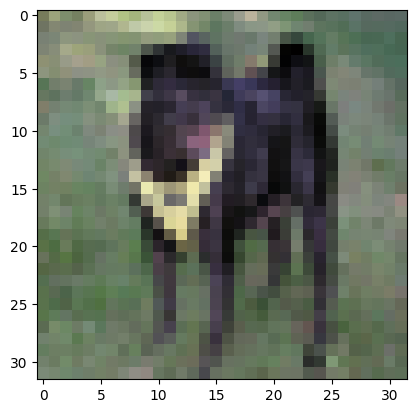

In [47]:
plt.imshow(x_test[0].reshape(32, 32, 3))
plt.show()